In [1]:
%matplotlib notebook 

In [2]:
from NBC_fonctions import *
import os

from CPclass import phone as CP



import lightgbm as lgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import signal,fft
from scipy.signal import find_peaks
import sys
import os
from scipy import stats
from pickle import load
import joblib

In [3]:
def findMiddle(input_list):
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        return int(middle - .5)
    else:
        return int(middle)
def calc_rms(data):
    return np.sqrt(np.mean(data ** 2))


def calc_mean_abs_deviation(data):
    return stats.median_abs_deviation(data)


def calc_data_entropy(data):
    value, counts = np.unique(data, return_counts=True)
    return stats.entropy(counts)

def calc_index_max(data):
    data = list(data)
    return data.index(min(data))

def calc_index_min(data):
    data = list(data)
    return data.index(max(data))

def calc_energy(data):
    squares = data ** 2
    return squares.sum()

def calc_sma(data):
    absolute = list(map(abs, data))
    return sum(absolute)


def _dominant_frequency(signal_x, sampling_rate=100):

    signal_x = signal_x-np.mean(signal_x)
    dim = signal_x.shape
    
    #valerie from matlab
    nfft=1024
    freq_hat = np.fft.fftfreq(nfft) * sampling_rate
    
    #freq are freq from 0 to 50 hz
    freq = freq_hat[0:nfft // 2]
    
    #valerie from matlab
    fmin=0.5
    fmax=4 
    lowind=np.where(freq>fmin)[0][0]
    upind=np.max(np.where(freq<fmax))

    # fourier transform
    #valerie add hamming
    # nfft is used for padding
    haming= np.hamming(dim[0])
    sp_hat = np.fft.fft(signal_x*haming, nfft)
    furval = sp_hat[0:nfft // 2] * np.conjugate(sp_hat[0:nfft // 2])
    furval=furval/sum(furval)

    #from the internet
    # cutoff is 12 
    cutoff=12.0
    idx1 = freq <= cutoff
    idx_cutoff = np.argwhere(idx1)
    #all freq less than cutoff
    freq = freq[idx_cutoff]
    #keep values less than cutoff
    sp = furval[idx_cutoff]
    #normalise
    sp_norm = sp / sum(sp)
    furval=furval/sum(furval)

    max_freq = freq[sp_norm.argmax()][0] # Feature 1: dominant freq 
    max_freq_val = sp_norm.max().real    #Feature 2: magnitude of dominant freq
    idx2 = (freq > max_freq - 0.5) * (freq < max_freq + 0.5)  
    idx_freq_range = np.where(idx2)[0]
    dom_freq_ratio = sp_norm[idx_freq_range].real.sum() #Feature 3: dominant frequency ratio

    # Calculate Feature 4: spectral flatness 
    spectral_flatness = 10.0*np.log10(stats.mstats.gmean(sp_norm)/np.mean(sp_norm))

    # Calculate Feature 5: Estimate spectral entropy
    spectral_entropy_estimate = 0
    for isess in range(len(sp_norm)):
        if sp_norm[isess] != 0:
            logps = np.log2(sp_norm[isess])
        else:
            logps = 0
        spectral_entropy_estimate = spectral_entropy_estimate - logps * sp_norm[isess]

    spectral_entropy_estimate = spectral_entropy_estimate / np.log2(len(sp_norm))

    # from valerie matlab
    Ns=10
    domfreq=np.zeros((1,3))
    fourcoef=np.zeros((1,3), dtype=complex)
    fourcoef[0,0]=(furval[lowind+np.argmax(np.abs(furval[lowind:upind]))])
    ind=lowind+np.argmax(np.abs(furval[lowind:upind]))
    idx=np.where(furval==fourcoef[0,0])[0][0]
    domfreq[0,0]=freq[idx] # it is equal to the maximum frequency ==Max_freq 
    furval[np.maximum(1,ind-Ns):(ind+Ns)]=0 
    fourcoef[0,1]=(furval[lowind+np.argmax(np.abs(furval[lowind:upind]))])
    ind=lowind+np.argmax(np.abs(furval[lowind:upind]))
    idx=np.where(furval==fourcoef[0,1])[0][0]
    domfreq[0,1]=freq[idx] #second dominant freq
    furval[np.maximum(1,ind-Ns):(ind+Ns)]=0
    fourcoef[0,2]=(furval[lowind+np.argmax(np.abs(furval[lowind:upind]))])
    ind=lowind+np.argmax(np.abs(furval[lowind:upind]))
    idx=np.where(furval==fourcoef[0,2])[0][0]
    domfreq[0,2]=freq[idx] #Third dominant freq

    return max_freq,max_freq_val,dom_freq_ratio,spectral_flatness[0].real,spectral_entropy_estimate[0].real,domfreq

6 fichiers importés avec succès


<IPython.core.display.Javascript object>


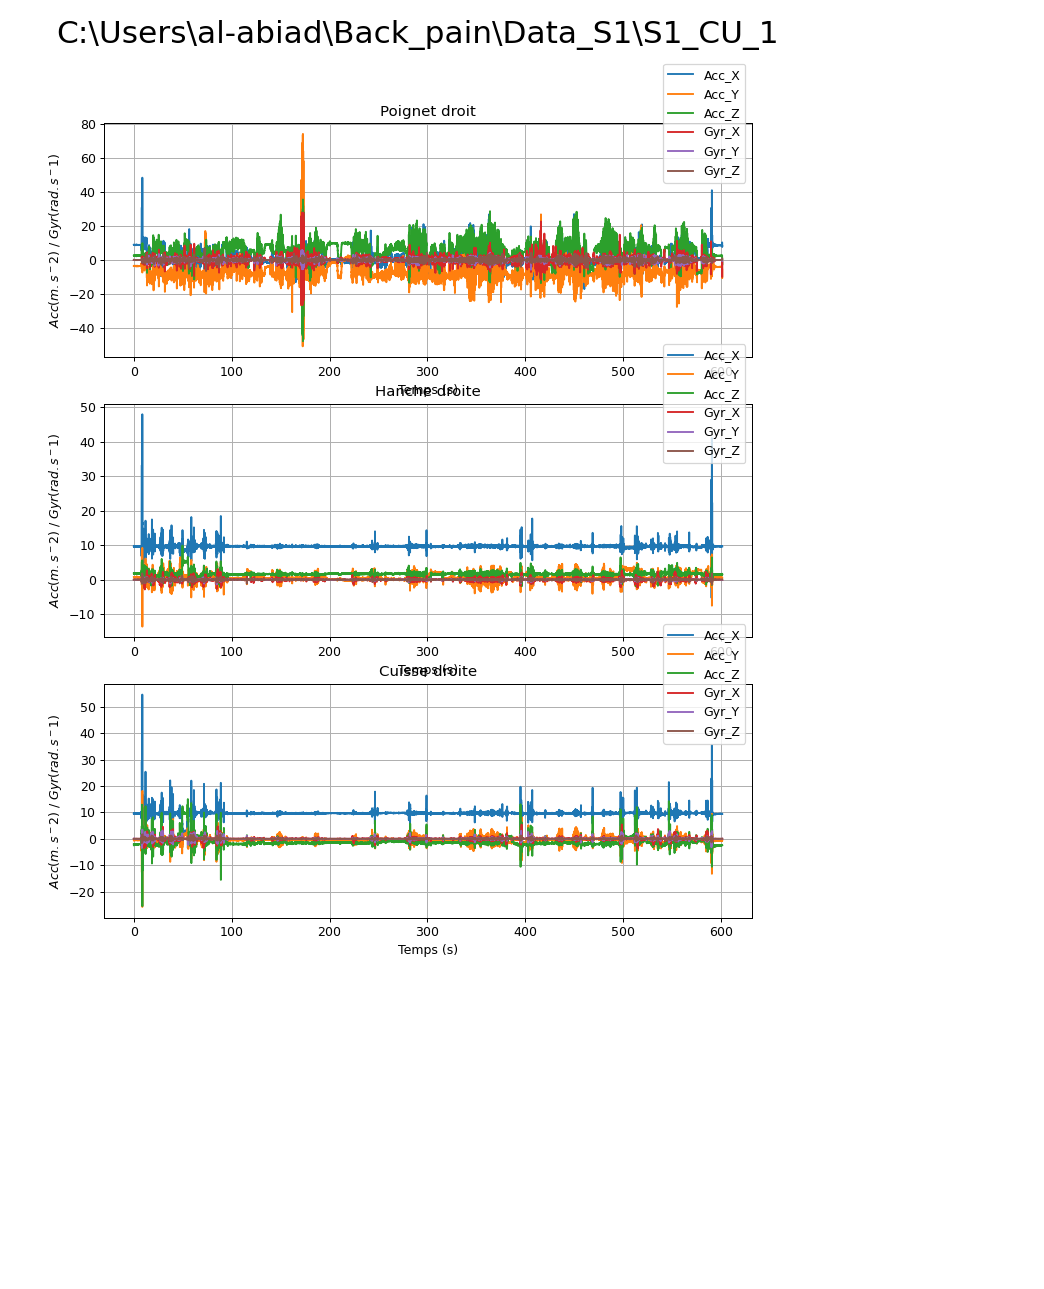

Signaux de 3 capteurs affichés avec succès


In [21]:
dossier=os.getcwd()+'\\Data_S1\\S1_CU_1'


exceptions=["S1_CU_1_gaitupraw.BIN","S1_CU_1_phone.csv"]

DATA,NAME,FREQ,ETIQUETTE,ind_a_tracer=importation(dossier,exceptions)
plot_signaux(DATA,ind_a_tracer,ETIQUETTE,dossier) 

In [5]:
# index 1 is the hand
print(DATA[1].head())
print("the Acc columns of xsens data are {0}".format(DATA[0].columns[0:3]))
print("the Gyr columns of xsens data are {0}".format(DATA[0].columns[3:]))

print(ETIQUETTE)
print(ind_a_tracer)

             Acc_X     Acc_Y     Acc_Z     Gyr_X     Gyr_Y     Gyr_Z
0.000000  8.953857 -3.475342  2.541504  0.002747  0.017967  0.032043
0.016667  8.925591 -3.450737  2.489376 -0.018883  0.012817  0.024605
0.033334  8.884277 -3.457031  2.545166 -0.014648  0.017967  0.027924
0.050001  8.837929 -3.432484  2.568913 -0.009384  0.005722  0.027351
0.066669  8.869629 -3.409424  2.585449 -0.010529  0.001488  0.033417
the Acc columns of xsens data are Index(['Acc_X', 'Acc_Y', 'Acc_Z'], dtype='object')
the Gyr columns of xsens data are Index(['Gyr_X', 'Gyr_Y', 'Gyr_Z'], dtype='object')
['Poignet droit', 'Hanche droite', 'Cuisse droite']
[1, 3, 5]


### Interpolate to 100 Hz to use with smartstep

In [6]:
df=DATA[1].copy()
time=DATA[1].index.values

fs=100
t_t=np.linspace(0, time[-1], num=np.int(time[-1]*fs), endpoint=True,dtype=np.float32)
t_t

df=df.reindex(df.index.union(t_t))
df=df.interpolate(method='linear', limit_direction='both', axis=0)
df=df[df.index.isin(pd.Index(t_t))]

df.index=np.around(df.index.astype('float64'),decimals=4)

In [7]:
Gyro=df[df.columns[3:]]
Acc=df[df.columns[0:3]]
Gyro

Gyr_X     Gyr_Y     Gyr_Z
0.00    0.002747  0.017967  0.032043
0.01   -0.008068  0.015392  0.028324
0.02   -0.017471  0.014534  0.025711
0.03   -0.016060  0.016251  0.026817
0.04   -0.012894  0.013885  0.027733
...          ...       ...       ...
601.21 -3.703699 -0.213114  0.772537
601.22 -2.480054 -0.359754  0.792227
601.23 -2.011788 -0.411056  0.800220
601.24 -1.347356 -0.495544  0.766664
601.25 -1.151190 -0.528730  0.725116

[60125 rows x 3 columns]

In [8]:
Xsens_data=CP(acc=Acc,gyro=Gyro,app="manual_entry")

In [9]:
Xsens_data.filter_data(acc=Xsens_data.acc_interp,gyro=Xsens_data.gyro_interp,N=10,fc=2,fs=100)

acc_filtered=Xsens_data.acc_filtered
gyro_filtered=Xsens_data.gyro_filtered

plt.figure()
plt.plot(gyro_filtered)

<IPython.core.display.Javascript object>

In [10]:
Xsens_data.calculate_norm_accandgyro(gyro=gyro_filtered,acc=acc_filtered)

plt.figure()
plt.plot(Xsens_data.acc_magnitude)

plt.figure()
plt.plot(Xsens_data.gyro_magnitude)

acc_mag_filtered=Xsens_data.acc_magnitude
gyro_mag_filtered=Xsens_data.gyro_magnitude

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
Xsens_data.calculate_norm_accandgyro(gyro=Xsens_data.gyro_interp,acc=Xsens_data.acc_interp)

plt.figure()
plt.plot(Xsens_data.acc_magnitude)

plt.figure()
plt.plot(Xsens_data.gyro_magnitude)

acc_mag_unfiltered=Xsens_data.acc_magnitude

gyro_mag_unfiltered=Xsens_data.gyro_magnitude

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
window_size80= 80
window_size5= 5
window_size30= 30
window_size20= 20
window_size50= 50
window_size60= 60
window_size70= 70
window_slide_step=1
window_freq=128

acc_features=pd.DataFrame()
gyro_features=pd.DataFrame()

s=0


signals=[acc_mag_filtered,gyro_mag_filtered]

signals_unfiltered=[acc_mag_unfiltered,gyro_mag_unfiltered]

########Feature Calculation#######
for sig in signals:
    print("calculating both signals")
    acc_minindex_win30=[]
    acc_skew_win5=[]
    acc_median_win80=[]
    acc_valleyprom_win80=[]
    acc_peakprom_win80=[]
    acc_peakprom_win50=[]
    acc_domfreq1=[]
    acc_kurt_win30=[]

    gyro_maxindex_win60=[]
    gyro_skew_win70=[]
    gyro_skew_win30=[]
    gyro_maxfreqvalue=[]
    gyro_SMA_win80=[]
    gyro_var_win20=[]
    gyro_maxvalue_win70=[]
    gyro_valleyprom_win80=[]


    for i in range(window_freq//2,len(sig)-window_freq//2,window_slide_step):

        mag30=sig[i-(window_size30//2):i+1+(window_size30//2)]
        mag30_nomean=mag30-np.mean(mag30)

        mag5=sig[i-(window_size5//2):i+1+(window_size5//2)]


        mag80=sig[i-(window_size80//2):i+1+(window_size80//2)]
        mag80_nomean=mag80-np.mean(mag80)

        mag50=sig[i-(window_size50//2):i+1+(window_size50//2)]
        mag50_nomean=mag50-np.mean(mag50)

        mag60=sig[i-(window_size60//2):i+1+(window_size60//2)]


        mag70=sig[i-(window_size70//2):i+1+(window_size70//2)]


        mag20=sig[i-(window_size20//2):i+1+(window_size20//2)]
        mag20_nomean=mag20-np.mean(mag20)


        mag_freq=signals_unfiltered[s][i-window_freq//2:i+(window_freq//2)+1]


        #===============================================

        if s==0:
            print("calculating acceleration")
            
            acc_minindex_win30.append(calc_index_min(mag30_nomean))
            
            acc_skew_win5.append(stats.skew(mag5))
            acc_median_win80.append(np.median(mag80))
            acc_kurt_win30.append(stats.kurtosis(mag30))

            peak_index,peak_properties= find_peaks(mag80_nomean,prominence=(None,None)) 
            if peak_index.size>0:
                ind_mid=findMiddle(peak_index)
                acc_peakprom_win80.append(peak_properties["prominences"][ind_mid])
            else:
                acc_peakprom_win80.append(50)

            peak_index,peak_properties= find_peaks(mag50_nomean,prominence=(None,None)) 
            if peak_index.size>0:
                ind_mid=findMiddle(peak_index)
                acc_peakprom_win50.append(peak_properties["prominences"][ind_mid])
            else:
                acc_peakprom_win50.append(50)

            valley_index,valley_properties= find_peaks(-mag80_nomean,prominence=(None,None))
            if valley_index.size>0:
                ind_mid=findMiddle(valley_index)
                acc_valleyprom_win80.append(valley_properties["prominences"][ind_mid])
            else:
                acc_valleyprom_win80.append(50)

            _,_,_,_,_,domfreq=_dominant_frequency(mag_freq)


            acc_domfreq1.append(domfreq[0,0])



        if s==1:
            print("gyro")
            gyro_skew_win70.append(stats.skew(mag70))
            gyro_skew_win30.append(stats.skew(mag30))
            gyro_maxindex_win60.append(calc_index_max(mag60))
            gyro_SMA_win80.append(calc_sma(mag80_nomean))
            gyro_var_win20.append(np.var(mag20_nomean))
            gyro_maxvalue_win70.append(np.amax(mag70))
            valley_index,valley_properties= find_peaks(-mag80_nomean,prominence=(None,None))

            if valley_index.size>0:
                ind_mid=findMiddle(valley_index)
                gyro_valleyprom_win80.append(valley_properties["prominences"][ind_mid])
            else:
                gyro_valleyprom_win80.append(50)

            _,max_fr_val,_,_,_,_=_dominant_frequency(mag_freq)

            gyro_maxfreqvalue.append(max_fr_val)

    if s==0: 
        print("acceleration features")
        acc_features['acc_indMin_win30']=acc_minindex_win30
        acc_features['acc_skew_win5']=acc_skew_win5
        acc_features['acc_Median_win80']=acc_median_win80
        acc_features['acc_peak_prominences80']=acc_peakprom_win80
        acc_features['acc_peak_prominences50']=acc_peakprom_win50
        acc_features['acc_valley_prominences80']=acc_valleyprom_win80
        acc_features['acc_domfreq1']=acc_domfreq1
        acc_features['acc_kurt_win30']=acc_kurt_win30
        acc_features=acc_features

    if s==1:
        print("gyroscope features")
        gyro_features['gyro_skew_win70']=gyro_skew_win70
        gyro_features['gyro_skew_win30']=gyro_skew_win30
        gyro_features['gyro_indMax_win60']=gyro_maxindex_win60
        gyro_features['gyro_SMA_win80']=gyro_SMA_win80
        gyro_features['gyro_var_win20']=gyro_var_win20
        gyro_features['gyro_Max_win70']=gyro_maxvalue_win70
        gyro_features['gyro_valley_prominences80']=gyro_valleyprom_win80
        gyro_features['gyro_max_freq_val']=gyro_maxfreqvalue
        gyro_features=gyro_features
    s=s+1

calculating both signals
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration


calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
calculating acceleration
acceleration features
calculating both signals
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyr

gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro


gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyro
gyroscope features


In [13]:
feat_gyro=['gyro_indMax_win60',
 'gyro_skew_win70',
 'gyro_max_freq_val',
 'gyro_SMA_win80',
 'gyro_skew_win30',
 'gyro_var_win20',
 'gyro_Max_win70',
 'gyro_valley_prominences80']

feat_acc=['acc_indMin_win30', 'acc_skew_win5', 'acc_Median_win80',
        'acc_kurt_win30',
       'acc_valley_prominences80', 'acc_peak_prominences80',
       'acc_peak_prominences50',  'acc_domfreq1']

In [14]:
joblib_file = "d:\\Users\\al-abiad\\Desktop\\experiments\\treadmill\\machine_learning_features\\joblib_Model_accv3.pkl" 
Model_acc = joblib.load(joblib_file)
joblib_file = "d:\\Users\\al-abiad\\Desktop\\experiments\\treadmill\\machine_learning_features\\joblib_Model_gyrov3.pkl" 
Model_gyro = joblib.load(joblib_file)
steps_in_window=[]
maxprobacc=0.5
maxprobgyro=0.5
index=0

In [15]:
stepacc=True
steps_in_window=[]
changethreshacc=0
changethreshgyro=0
maxprobacc=0.5
maxprobgyro=0.5
nostep_distance=0
threshdistance=80
count=0
stepacc=False
stepgyro=False
distance_cond=False
index=0
while index< len(gyro_features):
# for index, window in X_test.iterrows():
    
    featgyro=gyro_features.iloc[index,:][feat_gyro]
    featacc=acc_features.iloc[index,:][feat_acc]
    
    

    y_predprobacc= Model_acc.predict_proba([featacc])

    y_predprobgyro= Model_gyro.predict_proba([featgyro])
    


    
    if (y_predprobgyro[0][1]>maxprobgyro):
        steps_in_window.append(1)
        print("Model is gyro")
        index=index+1
        distance=0
        while distance<80 and index<len(gyro_features):
            print("entered loop")
            featgyro=gyro_features.iloc[index,:][feat_gyro]
            y_predprobgyro= Model_gyro.predict_proba([featgyro])
            
            if(y_predprobgyro[0][1]>maxprobgyro):
                print("step is gyro")
                steps_in_window.append(1)
                distance=0
            else:
                distance=distance+1
                steps_in_window.append(0)
            index=index+1
        
        if index<len(gyro_features):
            print("we entered condition")
            index=index-50
            steps_in_window=steps_in_window[:-50]
            
                
    elif (y_predprobacc[0][1]>maxprobacc):
        steps_in_window.append(1)
        print("Model is acc")
        index=index+1
        distance=0
        print(index)
        while distance<80 and index<len(gyro_features):
            featacc=acc_features.iloc[index,:][feat_acc]
            y_predprobacc= Model_acc.predict_proba([featacc])
            print(index)
            if(y_predprobacc[0][1]>maxprobacc):
                print("step is acc")
                steps_in_window.append(1)
                distance=0
            else:
                distance=distance+1
                steps_in_window.append(0)
            index=index+1
        
        if index<len(gyro_features):
            print("we entered condition")
            index=index-50
            steps_in_window=steps_in_window[:-50]
            

    else:
        steps_in_window.append(0)
        print("irregular or static")
        index=index+1

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
step is acc
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregul

2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
step is acc
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
step is acc
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
step is acc
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop

Model is acc
3373
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
step is acc
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
step is acc
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
step is acc
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3

4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
we entered condition
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loo

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
step is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop

8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static

9052
9053
9054
9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068
9069
9070
9071
9072
9073
9074
9075
9076
9077
9078
9079
9080
9081
9082
9083
9084
9085
9086
9087
9088
9089
9090
9091
9092
9093
9094
9095
9096
9097
9098
9099
9100
9101
9102
9103
9104
9105
9106
9107
9108
9109
9110
9111
9112
9113
9114
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irre

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
step is acc
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irr

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
11131
11131
11132
11133
11134
11135
11136
11137
11138
11139
11140
11141
11142
11143
11144
11145
11146
11147
11148
11149
11150
11151
11152
11153
11154
11155
11156
11157
11158
11159
11160
11161
11162
11163
11164
11165
11166
11167
11168
11169
11170
11171
11172
11173
11174
11175
11176
11177
11178
11179
11180
11181
11182
11183
11184
11185
11186
11187
11188
11189
11190
11191
11192
11193
11194
11195
11196
11197
11198
11199
11200
11201
11202
11203
11204
11205
11206
11207

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered l

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


14072
14073
14074
14075
14076
14077
14078
14079
14080
14081
14082
14083
14084
14085
14086
14087
14088
14089
14090
14091
14092
14093
14094
14095
14096
14097
14098
14099
14100
14101
14102
14103
14104
14105
14106
14107
14108
14109
14110
14111
14112
14113
14114
14115
14116
14117
14118
14119
14120
14121
14122
14123
14124
14125
14126
14127
14128
14129
14130
14131
14132
14133
14134
14135
14136
14137
14138
14139
14140
14141
14142
14143
14144
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
i

14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
14620
14621
14622
14623
14624
14625
14626
14627
14628
14629
14630
14631
14632
14633
14634
14635
14636
14637
14638
14639
14640
14641
14642
14643
14644
14645
14646
14647
14648
14649
14650
14651
14652
14653
step is acc
14654
14655
14656
14657
14658
14659
14660
14661
14662
14663
14664
14665
14666
14667
14668
14669
14670
14671
14672
14673
14674
14675
14676
14677
14678
14679
14680
14681
14682
14683
14684
14685
14686
14687
14688
14689
14690
14691
14692
14693
14694
14695
14696
14697
14698
14699
14700
14701
14702
14703
14704
14705
14706
14707
14708
14709
14710
14711
14712
14713
14714
14715
14716
14717
14718
14719
14720
14721
14722
14723
14724
14725
14726
14727
14728
14729
14730
14731
14732
14733
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular o

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
en

entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
step is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
17459
17459
17460
17461
17462
17463
17464
17465
17466
17467
17468
17469
17470
17471
17472
17473
17474
17475
17476
17477
17478
17479
17480
17481
17482
17483
17484
17485
17486
17487
17488
17489
17490
17491
17492
17493
17494
17495
17496
17497
17498
17499
17500
17501
17502
17503
17504
17505
17506
17507
17508
17509
17510
17511
17512
17513
17514
17515
17516
17517
17518
17519
17520
17521
17522
17523
step is acc
17524
17525
17526
17527
17528
17529
17530
17531
17532
17533
17534
17535
17536
17537
17538
17539
17540
17541
17542
17543
17544
17545
17546
17547
17548
17549
17550
17551
17552
17553
17554
17555
17556
17557
17558
17559
17560
17561
17562
17563
17564
17565
17566
17567
17568
17569
17570
17571
17572
17573
17574
17575
17576
17577
17578
17579
17580
17581
17582
17583
17584
17585
17586
17587
17588
17589
175

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
18351
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered lo

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
19183
19183
19184
19185
19186
19187
19188
19189
19190
19191
19192
19193
19194
19195
19196
19197
19198
19199
19200
19201
19202
19203
19204
19205
19206
19207
19208
19209
19210
19211
19212
19213
19214
19215
19216
19217
19218
19219
19220
19221
19222
19223
19224
19225
19226
19227
19228
19229
19230
step is acc
19231
19232
19233
19234
19235
19236
19237
19238
19239
19240
19241
19242
19243
19244
19245
19246
19247
19248
19249
19250
19251
19252
19253
19254
19255
19256
19257
19258
19259
19260
19261
19262
19263
19264
19265
19266
19267
19268
19269
19270
19271
19272
19273
19274
19275
19276
19277
19278
19279
19280
19281
19282
19283
19284
19285
19286
19287
19288
19289
19290
19291
19292
19293
19294
19295
19296
19297
19298
19299
19300
19301
19302
19303
19304
19305
19306
19307

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
22204
22204
22205
22206
22207
22208
22209
22210
22211
22212
22213
22214
22215
22216
22217
22218
22219
22220
22221
22222
22223
22224
22225
22226
22227
22228
22229
22230
22231
22232
22233
22234
22235
22236
22237
22238
22239
22240
22241
22242
22243
22244
22245
22246
22247
22248
22249
22250
22251
22252
22253
22254
22255
22256
22257
22258
22259
22260
22261
22262
22263
22264
22265
22266
22267
22268
22269
22270
22271
22272
22273
22274
22275
22276
22277
22278
22279
22280
step is acc
22281
22282
22283
22284
22285
22286
22287
22288
22289
22290
22291
22292
22293
22294
22295
22296
22297
22298
22299
22300
22301
22302
22303
22304
22305
22306
22307
22308
22309
22310
22311
22312
22313
22314
22315
22316
22317
22318
22319
22320
22321
2

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


23305
23306
23307
23308
23309
23310
23311
23312
23313
23314
23315
23316
23317
23318
23319
23320
23321
23322
23323
23324
23325
23326
23327
23328
23329
23330
23331
23332
23333
23334
23335
23336
23337
23338
23339
23340
23341
23342
23343
23344
23345
23346
23347
23348
23349
23350
23351
23352
23353
23354
23355
23356
23357
23358
23359
23360
23361
23362
23363
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irreg

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
23885
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
28115
28115
28116
28117
28118
28119
28120
28121
28122
28123
28124
28125
28126
28127
28128
28129
28130
28131
28132
28133
28134
28135
28136
28137
28138
28139
28140
28141
28142
28143
28144
28145
28146
28147
28148
28149
28150
28151
28152
28153
28154
28155
28156
28157
28158
28159
28160
28161
28162
28163
28164
28165
28166
28167
28168
28169
28170
28171
28172
28173
28174
28175
28176
28177
28178
28179
28180
28181
28182
28

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
enter

29415
29416
29417
29418
29419
29420
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irr

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
29852
29852
29853
29854
29855
29856
29857
29858
29859
29860
29861
29862
29863
29864
29865
29866
29867
29868
29869
29870
29871
29872
29873
29874
29875
29876
29877
29878
29879
29880
29881
29882
29883
29884
29885
29886
29887
29888
29889
29890
29891
29892
29893
29894
29895
29896
29897
29898
29899
29900
29901
29902
29903
29904
29905
29906
29907
29908
29909
29910
29911
29912
29913
29914
29915
29916
29917
29918
29919
29920
29921
29922
29923
29924
29925
29926
29927
29928
29929
29930
29931
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
30272
30272
30273
30274
30275
30276
30277
30278
30279
30280
30281
30282
30283
30284
30285
30286
30287
30288
30289
30290
30291
30292
30293
30294
30295
30296
30297
30298
30299
30300
30301
30302
30303
30304
30305
30306
30307
30308
30309
30310
30311
30312
30313
30314
30315
30316
30317
30318
30319
30320
30321
30322
30323
30324
30325
30326
30327
30328
30329
30330
30331
30332
30333
30334
30335
30336
30337
30338
30339
30340
30341
30342
30343
30344
30345
30346
30347
30348
30349
30350
30351
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
30742
30743
30744
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or st

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


31548
31549
31550
31551
31552
31553
31554
31555
31556
31557
31558
31559
31560
31561
31562
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loo

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


33243
33244
33245
33246
33247
33248
33249
33250
33251
33252
33253
33254
33255
33256
33257
33258
33259
33260
33261
33262
33263
33264
33265
33266
33267
33268
33269
33270
33271
33272
33273
33274
33275
33276
step is acc
33277
33278
33279
33280
33281
33282
33283
33284
33285
33286
33287
33288
33289
33290
33291
33292
33293
33294
33295
33296
33297
33298
33299
33300
33301
33302
33303
33304
33305
33306
33307
33308
33309
33310
33311
33312
33313
33314
33315
33316
33317
33318
33319
33320
33321
33322
33323
33324
33325
step is acc
33326
33327
33328
33329
33330
33331
33332
33333
33334
33335
33336
33337
33338
33339
33340
33341
33342
33343
33344
33345
33346
33347
33348
33349
33350
33351
33352
33353
33354
33355
33356
33357
33358
33359
33360
33361
33362
33363
33364
33365
33366
33367
33368
33369
33370
33371
33372
33373
33374
33375
33376
33377
33378
33379
33380
33381
33382
33383
33384
33385
33386
33387
33388
33389
33390
33391
33392
33393
33394
33395
33396
33397
33398
33399
33400
33401
33402
33403
33404
3340

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered 

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
37202
37202
37203
37204
37205
37206
37207
37208
37209
37210
37211
37212
37213
37214
37215
37216
37217
37218
37219
37220
37221
37222
37223
37224
37225
37226
37227
37228
37229
37230
37231
37232
37233
37234
37235
37236
37237
37238
37239
37240
37241
37242
37243
37244
37245
37246
37247
37248
37249
37250
37251
37252
37253
37254
step is acc
37255
37256
37257
37258
37259
37260
37261
37262
37263
37264
37265
37266

entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
step is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


39007
39008
39009
39010
39011
39012
39013
39014
39015
39016
39017
39018
39019
39020
39021
39022
39023
39024
39025
39026
39027
39028
39029
39030
39031
39032
39033
39034
39035
39036
39037
39038
39039
39040
39041
39042
39043
39044
39045
39046
39047
39048
39049
39050
39051
39052
39053
39054
39055
39056
39057
39058
39059
39060
39061
39062
39063
39064
39065
39066
39067
39068
39069
39070
39071
39072
39073
39074
39075
39076
39077
39078
39079
39080
39081
39082
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irr

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
ent

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


40273
40274
40275
40276
40277
40278
40279
40280
40281
40282
40283
40284
40285
40286
40287
40288
40289
40290
40291
40292
40293
40294
40295
40296
40297
40298
40299
40300
40301
40302
40303
40304
40305
40306
40307
40308
40309
40310
40311
40312
40313
40314
40315
40316
40317
40318
40319
40320
40321
40322
40323
40324
40325
40326
40327
40328
40329
40330
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
ent

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
we entered c

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
step is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


43214
43215
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregul

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregul

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
en

48129
48130
step is acc
48131
48132
48133
48134
48135
48136
48137
48138
48139
48140
48141
48142
48143
48144
48145
48146
48147
48148
48149
48150
48151
48152
48153
48154
48155
48156
48157
48158
48159
48160
48161
48162
48163
48164
48165
48166
48167
48168
48169
48170
48171
48172
48173
48174
48175
48176
48177
48178
48179
48180
48181
48182
48183
48184
48185
48186
48187
48188
48189
48190
48191
48192
48193
48194
48195
48196
48197
48198
48199
48200
48201
48202
48203
48204
48205
48206
48207
48208
48209
48210
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or st

48764
48765
48766
48767
48768
48769
48770
48771
48772
48773
48774
48775
48776
48777
48778
48779
48780
48781
48782
48783
48784
48785
48786
48787
48788
48789
48790
48791
48792
48793
48794
48795
48796
48797
48798
48799
48800
48801
48802
48803
48804
48805
48806
48807
48808
48809
48810
48811
48812
48813
48814
48815
48816
48817
48818
48819
48820
48821
48822
48823
48824
48825
48826
48827
48828
48829
48830
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or stat

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


50207
50208
50209
50210
50211
50212
50213
50214
50215
50216
50217
50218
50219
50220
50221
50222
50223
50224
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entere

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
50584
50584
50585
50586
50587
50588
50589
50590
50591
50592
50593
50594
50595
50596
50597
50598
50599
50600
50601
50602
50603
50604
50605
50606
50607
50608
50609
50610
50611
50612
50613
50614
50615
50616
50617
50618
50619
50620
50621
50622
50623
50624
50625
50626
50627
50628
50629
50630
50631
50632
50633
50634
50635
50636
50637
50638
50639
50640
50641
50642
50643
50644
50645
50646
50647
50648
50649
50650
50651
50652
50653
50654
50655
50656
50657
50658
50659
50660
50661
50662
50663
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
51000
51000
51001
51002
51003
51004
51005
51006
51007
51008
51009
51010
51011
51012
51013
51014
51015
51016
51017
51018
51019
51020
51021
51022
51023
51024
51025
51026
51027
51028
51029
51030
51031
51032
51033
51034
51035
51036
51037
51038
51039
51040
51041
51042
51043
51044
51045
51046
51047
51048
51049
51050
51051
51052
51053
51054
51055
51056
51057
51058
51059
step is acc
51060
51061
51062
51063
51064
51065
51066
51067
51068
51069
51070
51071
51072
51073
51074
51075
51076
51077
51078
51079
51080
51081
51082
51083
51084
51085
51086
51087
51088
51089
51090
51091
51092
51093
51094
51095
51096
51097
51098
51099
51100
51101
51102
51103
51104
51105
51106
51107
51108
51109
51110
step is acc
51111
51112

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entere

52023
52024
52025
52026
52027
52028
52029
52030
52031
52032
52033
52034
52035
52036
52037
52038
52039
52040
52041
52042
52043
52044
52045
52046
52047
52048
52049
52050
52051
52052
52053
52054
52055
52056
52057
52058
52059
52060
52061
52062
52063
52064
52065
52066
52067
52068
52069
52070
52071
52072
52073
52074
52075
52076
52077
52078
52079
52080
52081
52082
52083
52084
52085
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
i

52532
52533
52534
52535
52536
52537
52538
52539
52540
52541
52542
52543
52544
52545
52546
52547
52548
52549
52550
52551
52552
52553
52554
52555
52556
52557
52558
52559
52560
52561
52562
52563
52564
52565
52566
52567
52568
52569
52570
52571
52572
52573
52574
52575
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loo

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is acc
52938
52938
52939
52940
52941
52942
52943
52944
52945
52946
52947
52948
52949
52950
52951
52952
52953
52954
52955
52956
52957
52958
52959
52960
52961
52962
52963
52964
52965
52966
52967
52968
52969
52970
52971
52972
52973
52974
52975
52976
52977
52978
52979
52980
52981
52982
52983
52984
52985
step is acc
52986
52987
52988
52989
52990
52991
52992
52993
52994
52995
52996
52997
52998
52999
53000
53001
53002
53003
53004
53005
53006
53007
53008
53009
53010
53011
53012
53013
53014
53015
53016
53017
53018
53019
53020
53021
53022
53023
53024
53025
53026
53027
53028
53029
53030
53031
53032
53033
53034
53035
53036
53037
53038
53039
53040
53041
53042
53043
53044
53045
53046
53047
53048
53049
53050
53051
53052
53053
step is acc
53054
53055
53056
53057
53058
53059
53060
53061
53062
53063
5

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


55274
55275
55276
55277
55278
55279
55280
55281
55282
55283
55284
55285
55286
55287
55288
55289
step is acc
55290
55291
55292
55293
55294
55295
55296
55297
55298
55299
55300
55301
55302
55303
55304
55305
55306
55307
55308
55309
55310
55311
55312
55313
55314
55315
55316
55317
55318
55319
55320
55321
55322
55323
55324
55325
55326
55327
55328
55329
55330
55331
55332
55333
55334
55335
55336
55337
55338
step is acc
55339
55340
55341
55342
55343
55344
55345
55346
55347
55348
55349
55350
55351
55352
55353
55354
55355
55356
55357
55358
55359
55360
55361
55362
55363
55364
55365
55366
55367
55368
55369
55370
55371
55372
55373
55374
55375
55376
55377
55378
55379
55380
55381
55382
55383
55384
55385
55386
55387
55388
55389
55390
55391
55392
55393
55394
55395
55396
55397
55398
55399
55400
55401
55402
55403
55404
55405
55406
55407
55408
55409
55410
55411
55412
55413
55414
55415
55416
55417
55418
we entered condition
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
enter

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
Model is acc
56208
56208
56209
56210
56211
56212
56213
56214
56215
56216
56217
56218
56219
56220
56221
56222
56223
56224
56225
56226
56227
56228
56229
56230
56231
56232
56233
56234
56235
56236
56237
56238
56239
56240
56241
56242
56243
56244
56245
56246
56247
56248
56249
56250
56251
56252
56253
56254
56255
56256
56257
56258
56259
56260
56261
56262
56263
56264
56265
56266
56267
56268
56269
56270
56271
56272
56273
56274
56275
56276
56277
56278
56279
56280
56281
56282
56283
56284
56285
56286
56287
we entered condition
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
Model is gyro
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered loop
entered 

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


58203
58204
58205
58206
58207
58208
58209
58210
58211
58212
58213
58214
58215
58216
58217
58218
58219
58220
58221
58222
58223
58224
step is acc
58225
58226
58227
58228
58229
58230
58231
58232
58233
58234
58235
58236
58237
58238
58239
58240
58241
58242
58243
58244
58245
58246
58247
58248
58249
58250
58251
58252
58253
58254
58255
58256
58257
58258
58259
58260
58261
58262
58263
58264
58265
58266
58267
58268
58269
58270
58271
58272
58273
58274
58275
58276
58277
step is acc
58278
58279
58280
58281
58282
58283
58284
58285
58286
58287
58288
58289
58290
58291
58292
58293
58294
58295
58296
58297
58298
58299
58300
58301
58302
58303
58304
58305
58306
58307
58308
58309
58310
58311
58312
58313
58314
58315
58316
58317
58318
58319
58320
58321
58322
58323
58324
58325
58326
58327
58328
58329
58330
58331
58332
58333
58334
58335
58336
58337
58338
58339
58340
58341
58342
58343
58344
58345
58346
58347
58348
58349
58350
58351
58352
58353
58354
58355
58356
58357
we entered condition
irregular or static
irreg

irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static
irregular or static


In [16]:
def inverse_window_step(windows):
    steps=[]
    ii=0
    for wind in windows:

        if wind==1:
            steps.append(64+ii)
        ii=ii+1
    return steps

In [17]:
steps_smartstep=inverse_window_step(steps_in_window)

<IPython.core.display.Javascript object>


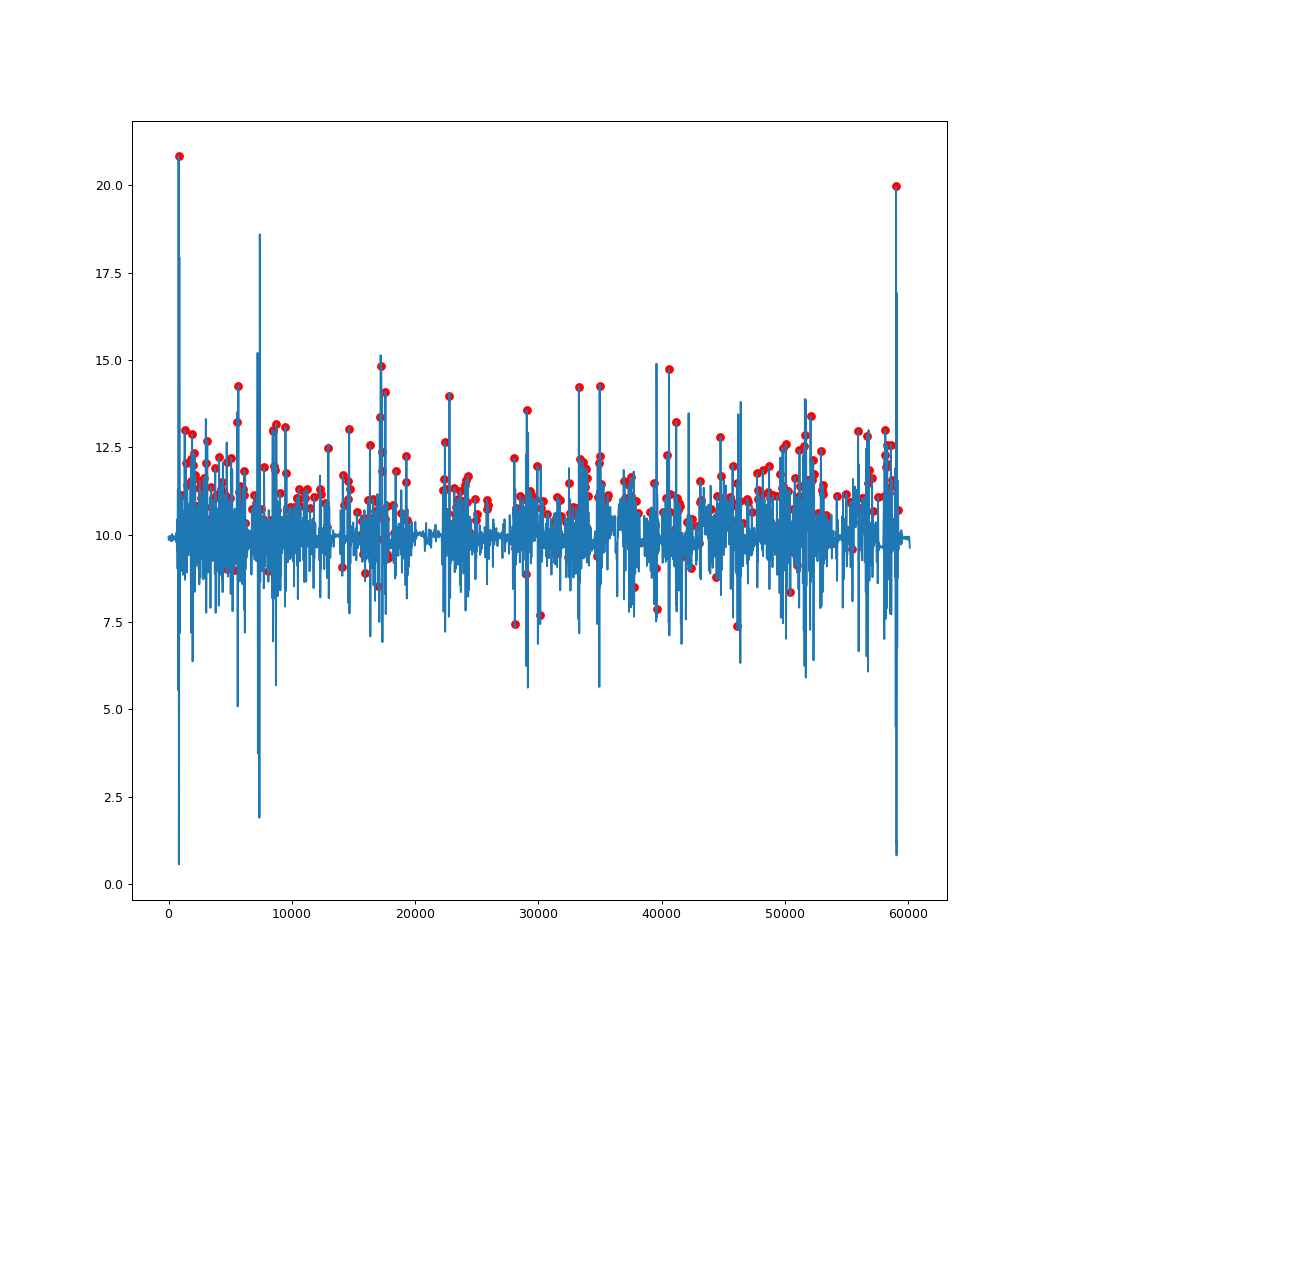

In [20]:
plt.figure()
plt.plot(acc_mag_filtered)
plt.scatter(steps_smartstep,acc_mag_filtered[steps_smartstep],c='r')

<IPython.core.display.Javascript object>


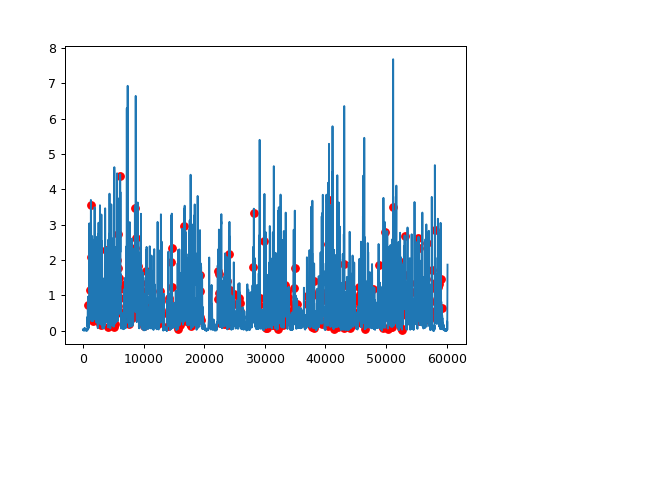

In [19]:
plt.figure()
plt.plot(gyro_mag_filtered)
plt.scatter(steps_smartstep,gyro_mag_filtered[steps_smartstep],c='r')